# FPLMonkey Notebook

In [1]:
!pip install lxml
!pip install bs4
!pip install backoff

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from helpers import *
from pathlib import Path
from fastai.tabular.all import *
from matplotlib import style

# Getting data

In [3]:
path = Path('./')

In [4]:
train_df = pd.read_csv(path/'data/train_v7.csv', index_col=0, dtype={'season':str, 
                                                                     'squad':str,
                                                                     'comp':str})

In [5]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
0,Aaron Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 109893 entries, 0 to 109896
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   player                                      109893 non-null  object 
 1   gw                                          109893 non-null  int64  
 2   position                                    109893 non-null  int64  
 3   minutes                                     109893 non-null  int64  
 4   team                                        109893 non-null  object 
 5   opponent_team                               109893 non-null  object 
 6   relative_market_value_team                  41830 non-null   float64
 7   relative_market_value_opponent_team         41807 non-null   float64
 8   was_home                                    109893 non-null  bool   
 9   total_points                                109893 non-null  int64  
 

In [7]:
train_df[train_df['season']=='2021']
train_df[train_df['gw']==32].head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
18519,Aaron Cresswell,32,2,0,West Ham United,Swansea City,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18520,Aaron Lennon,32,3,0,Everton,Leicester City,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18521,Aaron Ramsey,32,3,32,Arsenal,Crystal Palace,NaN,NaN,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18522,Aaron Wan-Bissaka,32,3,0,Crystal Palace,Arsenal,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18523,Abdoulaye Doucouré,32,3,58,Watford,Tottenham Hotspur,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Adding features to dataframe

In [8]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

In [67]:
# set validaton point/length and categorical/continuous variables
valid_season = "2021"
valid_gw = 25
valid_len = 1
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [68]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

In [69]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [70]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [71]:
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

In [72]:
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105642 entries, 0 to 105641
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   gw                                          105642 non-null  category
 1   minutes                                     105642 non-null  int64   
 2   minutes_last_1                              105642 non-null  float64 
 3   minutes_last_10                             105642 non-null  float64 
 4   minutes_last_2                              105642 non-null  float64 
 5   minutes_last_3                              105642 non-null  float64 
 6   minutes_last_4                              105642 non-null  float64 
 7   minutes_last_5                              105642 non-null  float64 
 8   minutes_last_all                            105642 non-null  int64   
 9   opponent_team                               105642 non-null

In [73]:
# need to remove 0 minute rows from the validation set
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                           ignore_index=True)

In [74]:
# and redo the valid indexes
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)

In [75]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(104900, 105202)

In [76]:
train_valid_df[cat_vars + ['player']].nunique()

gw                 38
season              5
position            4
team               30
opponent_team      30
was_home            2
player           1477
dtype: int64

In [77]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

In [78]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[FillMissing, Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

In [79]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [80]:
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,relative_market_value_team_season_na,relative_market_value_opponent_team_season_na,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points
0,8,1920,3,Manchester United,Newcastle United,False,Andreas Pereira,False,False,90.000000,1.679697,0.542356,2.0
1,22,1819,2,Wolverhampton Wanderers,Manchester City,False,Willy Boly,False,False,18.000001,0.388177,2.540586,-3.0
2,9,1920,3,Burnley,Leicester City,False,Dwight McNeil,False,False,90.000000,0.441800,0.886283,5.0
3,9,2021,3,Aston Villa,Brighton and Hove Albion,True,Mahmoud Ahmed Ibrahim Hassan,True,True,90.000000,0.704200,0.704200,2.0
4,28,1920,3,Brighton and Hove Albion,Crystal Palace,True,Aaron Mooy,False,False,90.000000,0.476156,0.495374,2.0
5,38,1718,4,Manchester United,Watford,True,Marcus Rashford,False,False,90.000000,2.110135,0.547242,8.0
6,24,1920,2,Leicester City,West Ham United,True,Ricardo Domingos Barbosa Pereira,False,False,90.000000,0.886283,0.739196,12.0
7,22,1718,3,Tottenham Hotspur,Swansea City,False,Heung-Min Son,False,False,90.000000,1.751141,0.560457,3.0
8,21,1718,2,Stoke City,Chelsea,False,Josh Tymon,False,False,90.000000,0.581587,2.125018,0.0
9,10,2021,2,Sheffield United,West Bromwich Albion,False,Max Lowe,True,True,90.000000,0.704200,0.704200,2.0


In [81]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

# Training a tabular learner from FastAI

In [82]:
# learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                         n_out=1, loss_func=F.mse_loss, metrics=rmse)

learn = tabular_learner(dls, y_range=y_range, layers=[500,250], loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

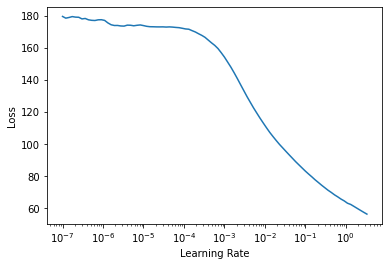

In [83]:
learn.lr_find()

In [ ]:
# [500, 250]
learn.fit_one_cycle(2, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,3.580276,6.587432,2.566599,00:23


In [ ]:
# check that rmse matches the training output above
preds,targs = learn.get_preds()
r_mse(preds,targs)

In [ ]:
preds.size()

In [ ]:
valid_gws = np.arange(valid_gw, valid_gw + valid_len, 1)
print(valid_gws)

In [ ]:
preds_gw_df = train_valid_df[['player'] + cat_vars + cont_vars + dep_var].copy()
preds_gw_df = preds_gw_df[preds_gw_df['gw'] == valid_gw]
preds_gw_df = preds_gw_df[preds_gw_df['season'] == valid_season]
preds_gw_df.info()

In [ ]:
preds_gw_df['predicted_points'] = preds.data.cpu().numpy()
preds_gw_df

In [ ]:
# get the precited points of a single player in a gw
player_prediction = preds_gw_df[preds_gw_df['player'] == 'Harry Kane'].predicted_points
player_prediction.iloc[0]

In [ ]:
# ordered by precited points
preds_gw_df.sort_values(by='predicted_points', ascending=False).head()

# Saving data to a csv file

In [ ]:
preds_gw_df.to_csv('data/predictions_for_season_' + str(valid_season) + '_gw_' + str(valid_gw) + '.csv')